# Word2Vec NN

In [17]:
FILE_NAME = "word2vec"
TITLE = "Word2Vec"

In [18]:
from utils.load_data import get_data, load_parquet_data

size = 's'

X_train, X_test, y_train, y_test = get_data(size)
print([X_train.shape, X_test.shape, y_train.shape, y_test.shape])


[(128000,), (32000,), (128000,), (32000,)]


## Fit Model

In [19]:
from gensim.models import Word2Vec

model_word2vec = Word2Vec.load("./output/word2vec.model")


In [20]:
import tensorflow as tf
import polars as pl
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.layers import Embedding
# from utils.word2vec import get_embedding_layer, GensimEmbedding

In [21]:
def get_embedding_layer(model):
    embedding_matrix = np.zeros((len(model.wv.index_to_key) + 1, model.vector_size))
    word2idx = {}

    vocab_list = [(word, model.wv[word]) for word in model.wv.index_to_key]
    for i, vocab in enumerate(vocab_list):
        word, vec = vocab
        embedding_matrix[i + 1] = vec
        word2idx[word] = i + 1

    embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False,
    )

    return embedding_layer


In [22]:
from keras.utils import pad_sequences

def process(texts):
    PADDING_LENGTH = 128
    supported_words = set(model_word2vec.wv.index_to_key)

    text_index = [[model_word2vec.wv.key_to_index[word] if word in supported_words else 0 for word in sentence] for sentence in texts]
    text_index = pad_sequences(text_index, maxlen=PADDING_LENGTH)
    return np.array(text_index)


In [23]:
import time
id = time.strftime('%H%M%S')

rnn = Sequential(name=f"{TITLE}_{id}")
rnn.add(get_embedding_layer(model_word2vec))
rnn.add(GRU(256, dropout=0.3, return_sequences=True))
rnn.add(GRU(128, dropout=0.3, return_sequences=True))
rnn.add(GRU(64, dropout=0.3, return_sequences=True))
rnn.add(GRU(32))
rnn.add(Dense(32, activation="relu"))
rnn.add(Dense(16, activation="relu"))
rnn.add(Dense(1, activation="sigmoid"))

# rnn.build((1,))
rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
rnn.summary()


Model: "Word2Vec_014113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         12709500  
                                                                 
 gru_4 (GRU)                 (None, None, 256)         428544    
                                                                 
 gru_5 (GRU)                 (None, None, 128)         148224    
                                                                 
 gru_6 (GRU)                 (None, None, 64)          37248     
                                                                 
 gru_7 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)            

In [24]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ckpt = tf.keras.callbacks.ModelCheckpoint(f'./output/model_nn/{FILE_NAME}_{id}_{size}_model.h5', monitor='val_loss', save_best_only=True, mode='auto')
board = tf.keras.callbacks.TensorBoard(log_dir=f"./output/model_nn/logs/{FILE_NAME}_{id}/", histogram_freq=1, embeddings_freq=1)

callbacks = [earlyStopping, ckpt, board]

In [25]:
X_train_processed = process(X_train)
X_test_processed = process(X_test)
y_train_processed = np.where(y_train == 'true', 1, 0)
y_test_processed = np.where(y_test == 'true', 1, 0)

In [26]:
result = rnn.fit(x=X_train_processed, y=y_train_processed, batch_size=500, epochs=10000, validation_split=0.4, callbacks=callbacks)


Epoch 1/10000
154/154 [==============================] - 17s 84ms/step - loss: 0.6906 - accuracy: 0.5270 - val_loss: 0.6897 - val_accuracy: 0.5401
Epoch 2/10000
154/154 [==============================] - 11s 73ms/step - loss: 0.6912 - accuracy: 0.5151 - val_loss: 0.6919 - val_accuracy: 0.5155
Epoch 3/10000
154/154 [==============================] - 12s 76ms/step - loss: 0.6848 - accuracy: 0.5435 - val_loss: 0.6818 - val_accuracy: 0.5490
Epoch 4/10000
154/154 [==============================] - 12s 81ms/step - loss: 0.6808 - accuracy: 0.5553 - val_loss: 0.6817 - val_accuracy: 0.5477
Epoch 5/10000
154/154 [==============================] - 14s 91ms/step - loss: 0.6807 - accuracy: 0.5542 - val_loss: 0.6819 - val_accuracy: 0.5477
Epoch 6/10000
154/154 [==============================] - 12s 76ms/step - loss: 0.6805 - accuracy: 0.5545 - val_loss: 0.6834 - val_accuracy: 0.5156
Epoch 7/10000
154/154 [==============================] - 13s 84ms/step - loss: 0.6777 - accuracy: 0.5631 - val_loss: 0

In [27]:
results = rnn.evaluate(X_test_processed, y_test_processed, batch_size=3000, return_dict=True)
print("Testing", results)

11/11 [==============================] - 1s 76ms/step - loss: 0.3774 - accuracy: 0.8849
Testing {'loss': 0.3773917257785797, 'accuracy': 0.8848749995231628}


In [28]:
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

from keras.utils import plot_model

plot_model(rnn, f"./output/model_nn/{FILE_NAME}_{id}_{size}_rnn_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


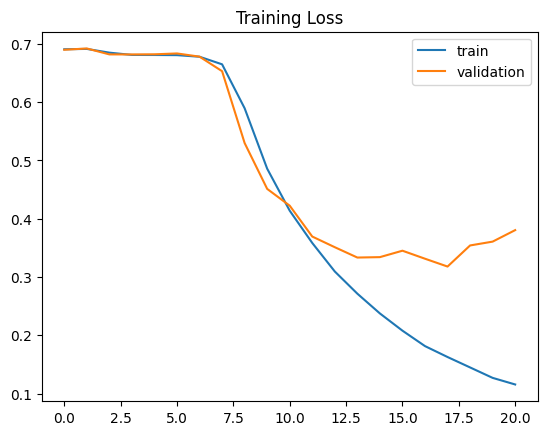

In [29]:
# Plot loss graph
import matplotlib.pyplot as plt

plt.title('Training Loss')
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig(f'./output/model_nn/{FILE_NAME}_{id}_{size}_rnn_model_loss.png')

In [30]:
new_model = tf.keras.models.load_model(f'./output/model_nn/{FILE_NAME}_{id}_{size}_model.h5')

In [31]:
def predict(text):
    text_processed = process([text])
    return new_model.predict(text_processed)

In [32]:
predict("Wow iot is the best requirement")

1/1 [==============================] - 1s 623ms/step


array([[0.9932515]], dtype=float32)